# Tutorial 1
This tutorial uses the WaveBot geometry in degree of freedom in regular waves. 
The goal is to find the optimal PTO force time-series to produce the most energy subject to a maximum force the PTO can excert.

First we will start by loading the neccessary modules and creating a save directory.

* Set the logging level (optional) to control the ammount of information printed to the screen
* Import Autograd (wrapper on NumPy, required) for automatic differentiation
* Import other packages we will use in this tutorial 
* Import WecOptTool 
* Create the Save directory if it doesn't exist


In [2]:
# logging
import logging
logging.basicConfig(level=logging.INFO)

# autograd (derivatives)
import autograd.numpy as np
from autograd.builtins import isinstance, tuple, list, dict

# other packages
import os

import capytaine as cpy
import matplotlib.pyplot as plt
import pygmsh
import gmsh

# wecopttool
import wecopttool as wot
from wecopttool.geom import WaveBot


# create save directory
results_dir = 'results_tutorial_1'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

* Create the WaveBot mesh:

In [3]:
wb = WaveBot() # use standard dimensions
mesh = wb.mesh(mesh_size_factor=0.5)

* Create a Capytaine floating body (mesh + DOFs). We will only model the HEAVE DOF.

In [3]:
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="HEAVE")

INFO:capytaine.bodies.bodies:Stored 23040 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.


* Change the density from default sea water to fresh water
* Create the mass and hydrostatic stiffness matrices. Since this is a 1 DOF problem these matrices are 1x1. We will use helper fnuctions in the `wecopttool.hydrostatics` submodule to do this.

In [4]:
rho = 1000.0

hs_data = wot.hydrostatics.hydrostatics(fb, rho=rho)
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
mass = np.atleast_2d(mass_33)
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
stiffness = np.atleast_2d(stiffness_33)


* Define the pseudo-spectral problem frequencies. We will use 50 frequencies with a spacing of 0.05 Hz

In [5]:
f0 = 0.05
nfreq = 50

* We will define a PTO from the `wecopttool.pto` submodule. This will supply our objective function (energy produced), and an external force for the WEC dynamics (which we will also constrain).

In [6]:
kinematics = np.eye(fb.nb_dofs)
pto = wot.pto.PseudoSpectralPTO(nfreq, kinematics)

* Add constraints: we will constraint the PTO force to 2000 N. We will enforce the constraint at 4 times more points than the dynamics. This is the only constraint.

In [7]:
nsubsteps = 4
f_max = 2000.0


def const_f_pto(wec, x_wec, x_opt):
    f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
    return f_max - np.abs(f.flatten())


ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

* Create the WEC

In [8]:
f_add = pto.force_on_wec  # PTO force

wec = wot.WEC(fb, mass, stiffness, f0, nfreq, f_add=f_add, rho=rho,
              constraints=constraints)


INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.


* Calculate (or read) the BEM data

In [9]:
fname = os.path.join(results_dir, 'bem.nc')
if os.path.exists(fname):
    wec.read_bem(fname)
else:
    wec.run_bem()
    wec.write_bem(fname)

INFO:wecopttool.core:Reading BEM data from results_tutorial_1/bem.nc.
INFO:wecopttool.core:  Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.


* Create a regular wave using the `wecopttool.waves` submodule.

In [10]:
wfreq = 0.3
amplitude = 0.0625
phase = -40
waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

* Solve the problem

In [11]:
options = {'maxiter': 1000, 'ftol': 1e-8}
obj_fun = pto.average_power
nstate_opt = pto.nstate
wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options)

INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -100.96299223976287
            Iterations: 528
            Function evaluations: 529
            Gradient evaluations: 528


* Post-process the optimized PTO results

In [12]:
pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

## Results
In this section we will save, view, and plot the results.
* Print results
* Save results

In [13]:
# print
print(f"\nEnergy produced from 0-{wec.tf}s: {obj} J")
print(f"Average power: {obj/wec.tf} W\n")

# save
fname = os.path.join(results_dir, 'wec_tdom.nc')
wec_tdom.to_netcdf(fname)

fname = os.path.join(results_dir, 'wec_fdom.nc')
wot.complex_xarray_to_netcdf(fname, wec_fdom)

fname = os.path.join(results_dir, 'pto_tdom.nc')
pto_tdom.to_netcdf(fname)

fname = os.path.join(results_dir, 'pto_fdom.nc')
wot.complex_xarray_to_netcdf(fname, pto_fdom)


Energy produced from 0-20.0s: -100.96299223976287 J
Average power: -5.048149611988143 W



* View the mesh (opens a new window that needs to be closed before continuing).

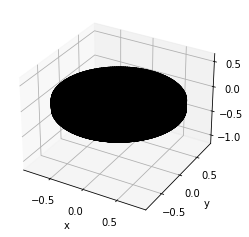

In [14]:
wec.fb.show() # will need to close window before continuing in notebook
wec.fb.show_matplotlib() # interactive outside Jupyter notebook.

* Plot impedance

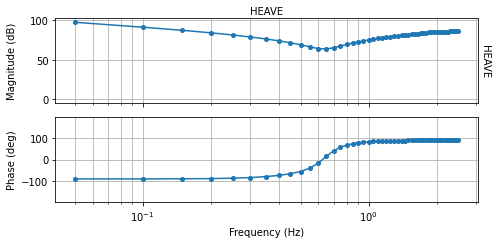

(<Figure size 504x252 with 3 Axes>,
 array([[<AxesSubplot:xlabel='HEAVE', ylabel='Magnitude (dB)'>],
        [<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Phase (deg)'>]],
       dtype=object))

In [15]:
wec.plot_impedance()  # see function doc for options.

* Example time-domain plots

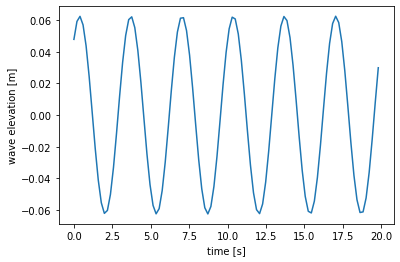

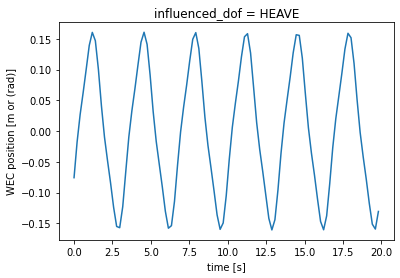

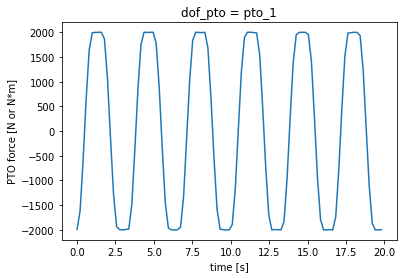

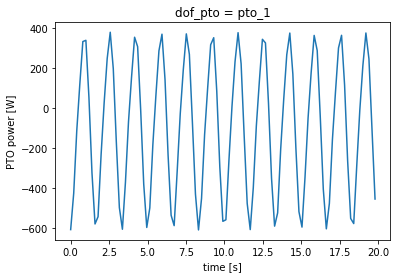

In [16]:
plt.figure()
wec_tdom['wave_elevation'].plot()

plt.figure()
wec_tdom['pos'].plot()

plt.figure()
pto_tdom['force'].plot()

plt.figure()
pto_tdom['power'].plot()

* Example frequency-domain plots

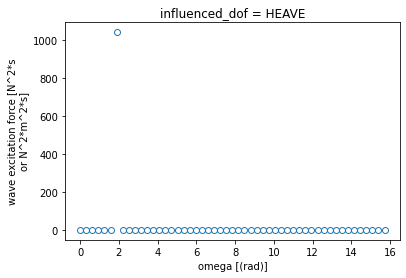

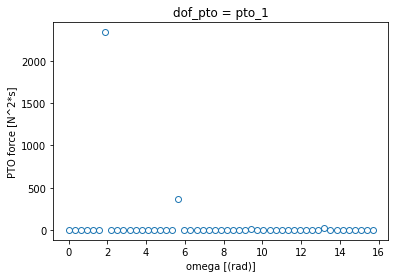

In [17]:
fd_lines = {'marker': 'o', 'linestyle': '', 'fillstyle': 'none'}

plt.figure()
np.abs(wec_fdom['excitation_force']).plot(**fd_lines)

plt.figure()
np.abs(pto_fdom['force']).plot(**fd_lines)

plt.show()

## Comparison to Conjugate Gradient Control
The unconstrained (no maximum PTO force) optimal control can be calculated analytically. We will compare the two results.

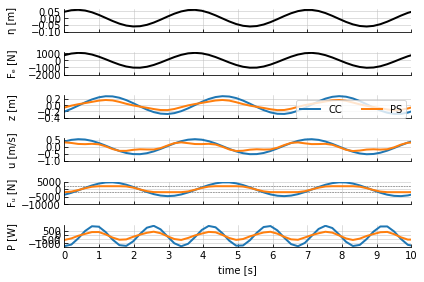

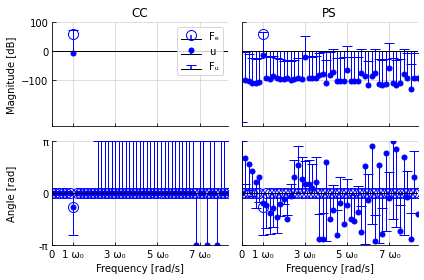

In [19]:
idof = 0
Fe = wec_fdom['excitation_force'][1:, idof]
Zi = wec.hydro.Zi[:, idof, idof]

cc_vel_fd = Fe / (2*Zi.real)
cc_pos_fd = cc_vel_fd / (1j*cc_vel_fd.omega)
cc_force_fd = -1.0 * Zi.conj() * cc_vel_fd

cc_pos_fd = np.concatenate([[0.0], cc_pos_fd])
cc_vel_fd = np.concatenate([[0.0], cc_vel_fd])
cc_force_fd = np.concatenate([[0.0], cc_force_fd])

cc_pos_td = wec.fd_to_td(cc_pos_fd)
cc_vel_td = wec.fd_to_td(cc_vel_fd)
cc_force_td = wec.fd_to_td(cc_force_fd)

cc_power_td = cc_vel_td * cc_force_td
cc_power_fd = wec.td_to_fd(cc_power_td)

Fe = wec_fdom['excitation_force'][:, idof]

# plot
ncases = 2

label_cc = 'CC'
label_ps = 'PS'
color_cc = 'tab:blue'
color_ps = 'tab:orange'
color_w = '0.0'
color_s = '0.25'
lw = 2

## Plot time domain
fig, axs = plt.subplots(nrows=6, sharex=True)

# plot PS force limits
xlim = 10.0
axs[4].plot([0.0, xlim], [f_max, f_max], '--', c=color_s, lw=0.5)
axs[4].plot([0.0, xlim], [-f_max, -f_max], '--', c=color_s, lw=0.5)

wec_tdom['wave_elevation'].plot(ax=axs[0], color=color_w, lw=lw)
wec_tdom['excitation_force'].sel(influenced_dof='HEAVE').plot(
    ax=axs[1], color=color_w, lw=lw)
axs[2].plot(wec.time, cc_pos_td, color=color_cc, label=label_cc, lw=lw)
wec_tdom['pos'].sel(influenced_dof='HEAVE').plot(
    ax=axs[2], color=color_ps, label=label_ps, lw=lw)
axs[3].plot(wec.time, cc_vel_td, color=color_cc, label=label_cc, lw=lw)
wec_tdom['vel'].sel(influenced_dof='HEAVE').plot(
    ax=axs[3], color=color_ps, label=label_ps, lw=lw)
axs[4].plot(wec.time, cc_force_td, color=color_cc, label=label_cc, lw=lw)
pto_tdom['force'].sel(dof_pto='pto_1').plot(
    ax=axs[4], color=color_ps, label=label_ps, lw=lw)  # marker='.'
axs[5].plot(wec.time, cc_power_td, color=color_cc, label=label_cc, lw=lw)
pto_tdom['power'].sel(dof_pto='pto_1').plot(
    ax=axs[5], color=color_ps, label=label_ps, lw=lw)

# format subplots
ylims = [0.05, 1000.0, 0.2, 0.5, 5000.0, 500.0]
names = ['η [m]', 'Fₑ [N]', 'z [m]', 'u [m/s]',
         'Fᵤ [N]', 'P [W]']
for ax, ylim, name in zip(axs, ylims, names):
    ax.set_title('')
    if ax is not axs[-1]:
        ax.set_xlabel('')
    ax.set_ylabel(name)
    ax.label_outer()
    ax.set_xticks([i for i in range(int(xlim)+1)], minor=False)
    ax.grid(color='0.75', linestyle='-', linewidth=0.5, which='major')
    ax.tick_params(direction='in')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([0.0, xlim])
    ax.set_yticks([-2*ylim, -ylim, 0, ylim], minor=False)
axs[2].legend(ncol=ncases, loc='upper right')

fig.align_ylabels(axs)
fig.tight_layout()


## Plot frequency domain
omega = np.concatenate([[0.0], wec.omega])
cases = [label_cc, label_ps]

fig, axs = plt.subplots(2, ncases, sharex='col', sharey='row')


def plot_fd(axs, omega, fdom, marker, label, rmface=False):

    def _plot_fd(ax, omega, fdom, marker, label, rmface=False):
        markers, stems, base = ax.stem(
            omega,
            fdom,
            basefmt='k-',
            linefmt='b-',
            markerfmt='b'+marker,
            label=label)
        width = 1.0
        stems.set_linewidth(width)
        base.set_linewidth(width)
        markers.set_markeredgewidth(width)
        markers.set_markersize(10)
        if rmface:
            markers.set_markerfacecolor('none')

    omega = omega / (wfreq*2*np.pi)
    mag = np.squeeze(20*np.log10(np.abs(fdom),
                     out=np.ones(fdom.shape)*np.nan, where=fdom != 0))
    ang = np.squeeze(np.angle(fdom))

    _plot_fd(axs[0], omega, mag, marker, label, rmface)
    _plot_fd(axs[1], omega, ang, marker, label, rmface)


iaxs = axs[:, 0]
plot_fd(iaxs, omega, Fe, 'o', 'Fₑ', True)
plot_fd(iaxs, omega, cc_vel_fd, '.', 'u')
plot_fd(iaxs, omega, cc_force_fd, '_', 'Fᵤ')

iaxs = axs[:, 1]
plot_fd(iaxs, omega, Fe, 'o', 'Fₑ', True)
plot_fd(iaxs, omega, wec_fdom['vel'], '.', 'u')
plot_fd(iaxs, omega, pto_fdom['force'], '_', 'Fᵤ')

# format subplots
locs = [1, 3, 5, 7]
ylims = [100.0, np.pi]
xlims = [0, omega[-1]/(wfreq*2*np.pi)]
for i in range(ncases):
    iaxs = axs if ncases == 1 else axs[:, i]
    for j in range(2):
        iaxs[j].set_xticks([0]+locs, minor=False)
        iaxs[j].set_yticks([-ylims[j], 0, ylims[j]], minor=False)
        iaxs[j].label_outer()
        iaxs[j].grid(color='0.75', linestyle='-',
                     linewidth=0.5, which='major')
        iaxs[j].tick_params(direction='in')
        iaxs[j].spines['right'].set_visible(False)
        iaxs[j].spines['top'].set_visible(False)
        iaxs[j].set_xlim(xlims)
        iaxs[j].set_xticklabels(['0']+[f'{k} ω₀' for k in locs])
    iaxs[1].set_yticklabels(["-π", 0, "π"], minor=False)
    iaxs[0].set_title(cases[i])
    iaxs[1].set_xlabel('Frequency [rad/s]')
    iaxs[1].set_ylim([-np.pi, np.pi])
    if i == 0:
        iaxs[0].legend(ncol=1, loc='upper right')
        iaxs[0].set_ylabel('Magnitude [dB]')
        iaxs[1].set_ylabel('Angle [rad]')
        fig.align_ylabels(iaxs)

fig.tight_layout()
